# Initialising an Underworld mesh with Topography from a Digital Elevation Model

Romain Beucher, romain.beucher@unimelb.edu.au 


We detail a workflow to quickly initialise an Underworld mesh with some initial topography.

The Idea is to build a function, that can be use to create an Underworld mesh with some topography from any DEM file.

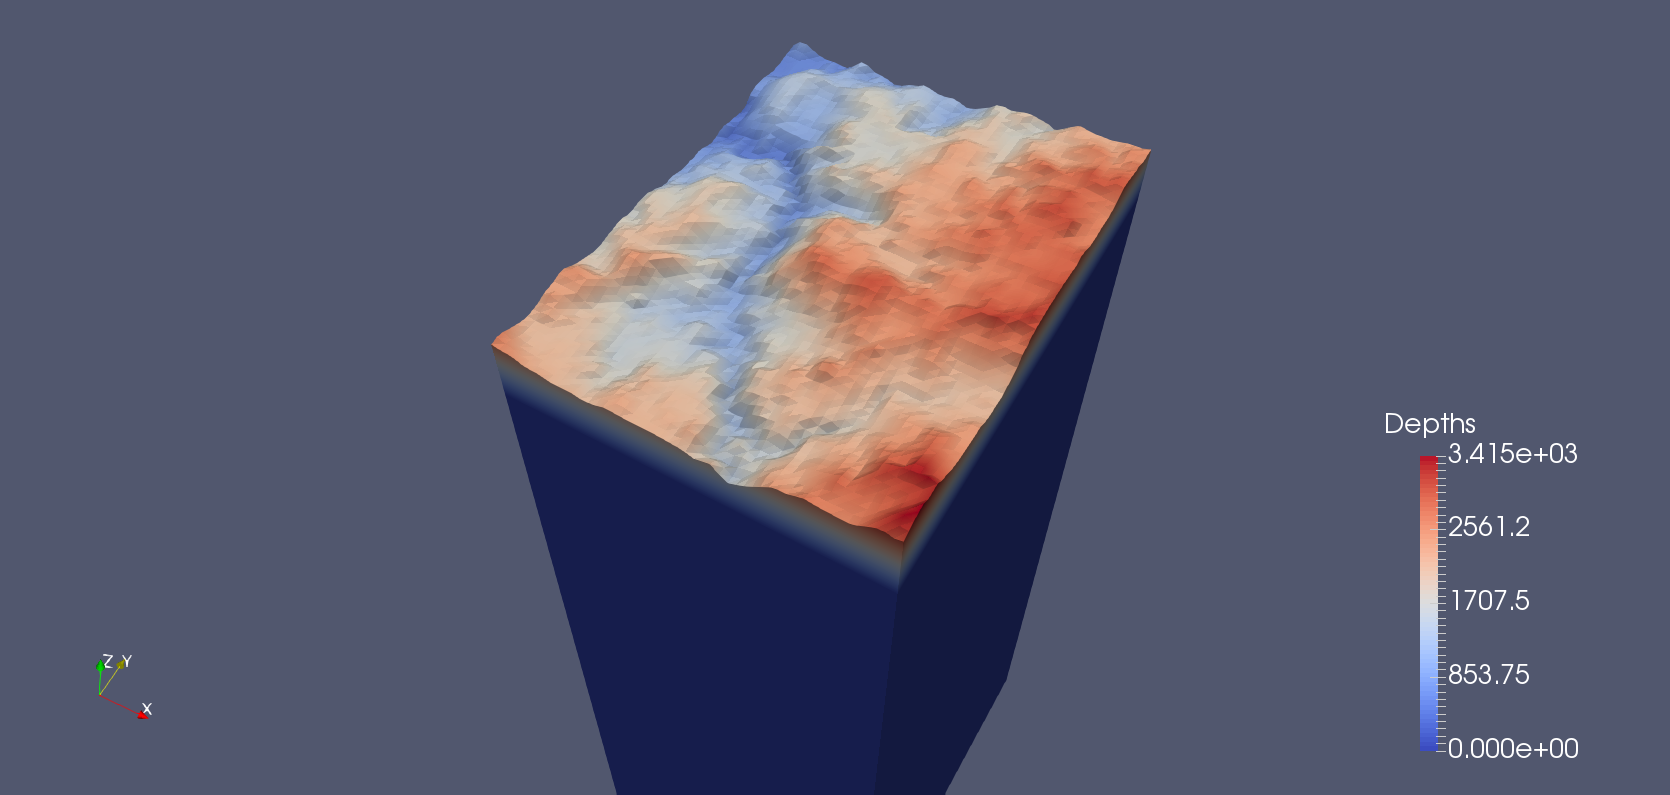

# Requirements

+ An up to date version of Underworld
+ [GDAL](http://www.gdal.org/) (which depends on libgdal)
+ A Digital Elevation Model

# Topographic Data

In our example, the DEM is an ASCII file with 3 columns, each line containing the X and Y coordinates of the nodes on a regular grid and its associated Z value. All units are in meters

I am providing 2 differents DEMs, one from the Kings Canyon area in California's Sierra Nevada mountains (known for its huge sequoia trees) and one from the Sydney basin. You can, of course, use other datasets. 

As a rule of thumb, all rasters (aerial, satellite images) use pixel-is-area and measurement data like DEMs use pixel-is-point. But in reality, things may be a bit more complicated and it is really up to the user to know what he is dealing with and if it is important...

I will not enter into the details of what projection the data should be in. Here our dataset uses a UTM projection.

In [ ]:
KingsCanyon = "KingsCanyon.xyz"
SydneyBasin = "Sydney_basin.dat"

Note that you do not need to provide a DEM in a specific format as we will be using GDAL. GDAL can handle most of the NETCDF formats, you can thus use .tif, .bil etc...

In [ ]:
import os

inDir = "./input/"
outDir = "./outputs/"

if not os.path.exists(inDir):
    os.makedirs(inDir)
if not os.path.exists(outDir):
    os.makedirs(outDir)

## XYZ ASCII DEM

   We can have a quick look at the data.  We use pandas for the sake of the example but you can just open it with anything you like. (Note that the 2 files use different separator, tabulations for the Sydney Basin DEM and spaces for the Kings Canyon DEM.)

In [ ]:
import pandas as pd

SydneyBasinDF = pd.read_csv(os.path.join(inDir, SydneyBasin), header=None, sep="\t", names=["X", "Y", "Z"])
KingsCanyonDF = pd.read_csv(os.path.join(inDir, KingsCanyon), header=None, sep=" ", names=["X", "Y", "Z"])

In [ ]:
SydneyBasinDF[0:10]

Now we need to know a bit more about the dataset, meaning the spacing, minimum coordinates etc.

You can find out all of that based on the description of your dataset. Another easy way is just to use the python module gdal which use the gdal library (behind most of the main GIS application).

GDAL support reading and writing most of the raster formats. It supports reading and writing ASCII gridded XYZ raster datasets (i.e. ungridded XYZ, LIDAR XYZ etc. must be opened by other means. See the documentation of the gdal_grid utility).

GDAL is fairly easy install on linux and Mac OSx systems. The easiest if to use anaconda on your machine and install GDAL by typing: 

                conda install gdal
                
GDAL can them be imported

In [ ]:
import gdal

...and we can then open the DEM:

In [ ]:
# open the dataset
ds = gdal.Open(os.path.join(inDir, KingsCanyon))

Note that the ASCII XYZ driver assumes that the coordinates correspond to the center of a cell. This may or may not be important depending on what you are willing to do.
In our case, it is really not that important as we just want to extract the elevations and apply them to the top of a mesh. We do not need to keep the geographical information.

The gdal driver extract metadata information from the file. We are going to use that to build our mesh. 

In [ ]:
# Get dimension of the grid in x and y
nx, ny = ds.RasterXSize, ds.RasterYSize
# Get some additional information such as spacing in x (dx) and y (dy)
minX, dx, _, minY, _, dy = ds.GetGeoTransform()
# Read the data as a numpy array
KingsCanyonElevation = ds.ReadAsArray()

Lets Quickly do the same thing for the Sydney Basin

In [ ]:
dsB = gdal.Open(os.path.join(inDir, SydneyBasin))
nxB, nyB = ds.RasterXSize, ds.RasterYSize
minXB, dxB, _, minYB, _, dyB = ds.GetGeoTransform()
SydneyBasinElevation = dsB.ReadAsArray()

It's always good to have a quick look at the data:

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# imshow is designed for plotting images... origin is set to the top left corner by default, we change that to be 
# the lower left corner.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
im1 = ax1.imshow(KingsCanyonElevation, origin="lower")
ax1.set_title("Kings Canyon")
im2 = ax2.imshow(SydneyBasinElevation, origin="lower")
ax2.set_title("Sydney Basin")
plt.show()

# Fire up UNDERWORLD


Lets now create a regular mesh using Underworld FeMesh_Cartesian:

In [ ]:
import underworld as uw
import math

xdim = ds.RasterXSize * math.fabs(dx)
ydim = ds.RasterYSize * math.fabs(dy)
nz, zdim = 40, 40000 

# We just set the origin to be at (0,0, -zdim)
minX, minY, minZ = (0., 0., -zdim)
maxX, maxY, maxZ = (xdim, ydim, 0.)

mesh = uw.mesh.FeMesh_Cartesian(elementType="Q1", elementRes=(nx - 1, ny - 1, nz - 1), minCoord = (minX, minY, minZ), maxCoord = (maxX, maxY, maxZ) )

A quick visualisation shows a regular mesh with a flat topography:

In [ ]:
import glucifer.lavavu as lavavu
import glucifer

In [ ]:
from underworld.utils import is_kernel

if is_kernel():

    Fig = glucifer.Figure(background="#51576e", border=False, axis=True)
    Fig.append(glucifer.objects.Mesh(mesh, linesize=10, opacity=0.5, name="Mesh"))

    lv = Fig.viewer(show=False)
    lv.control.Panel()
    lv.control.Range(command='scale z', range=(1,10), step=0.1, value=5)
    lv.control.ObjectList()
    lv.control.show()

## Deform the surface of the mesh according to Topography

In [ ]:
top = mesh.specialSets["MaxK_VertexSet"]

mesh.reset()
with mesh.deform_mesh():
    mesh.data[top.data, 2] = KingsCanyonElevation.flatten()

In [ ]:
if is_kernel():

    Fig = glucifer.Figure(background="#51576e", border=False, axis=True)
    Fig.append(glucifer.objects.Mesh(mesh, linesize=10, opacity=0.5, name="Mesh"))

    lv = Fig.viewer(show=False)
    lv.control.Panel()
    lv.control.Range(command='scale z', range=(1,10), step=0.1, value=5)
    lv.control.ObjectList()
    lv.control.show()

Now if you look carefully at the result, you will notice that only the nodes from the top row have been moved up or down in order to fit topography...
There are several issues with that:

* First of all, the top row elements are potentially going to be very deformed compared to the other elements. We want to keep those elements roughly the same size...
    
* Second, some nodes may have been moved below some of the nodes from the rows below..

Visualisation of the Sydney Basin DEM shows exactly that: some of the nodes at the surface have been moved down below there underlying neighbors. The topology of the mesh is not respected, some elements overlay other elements... which is likely to lead to issues.

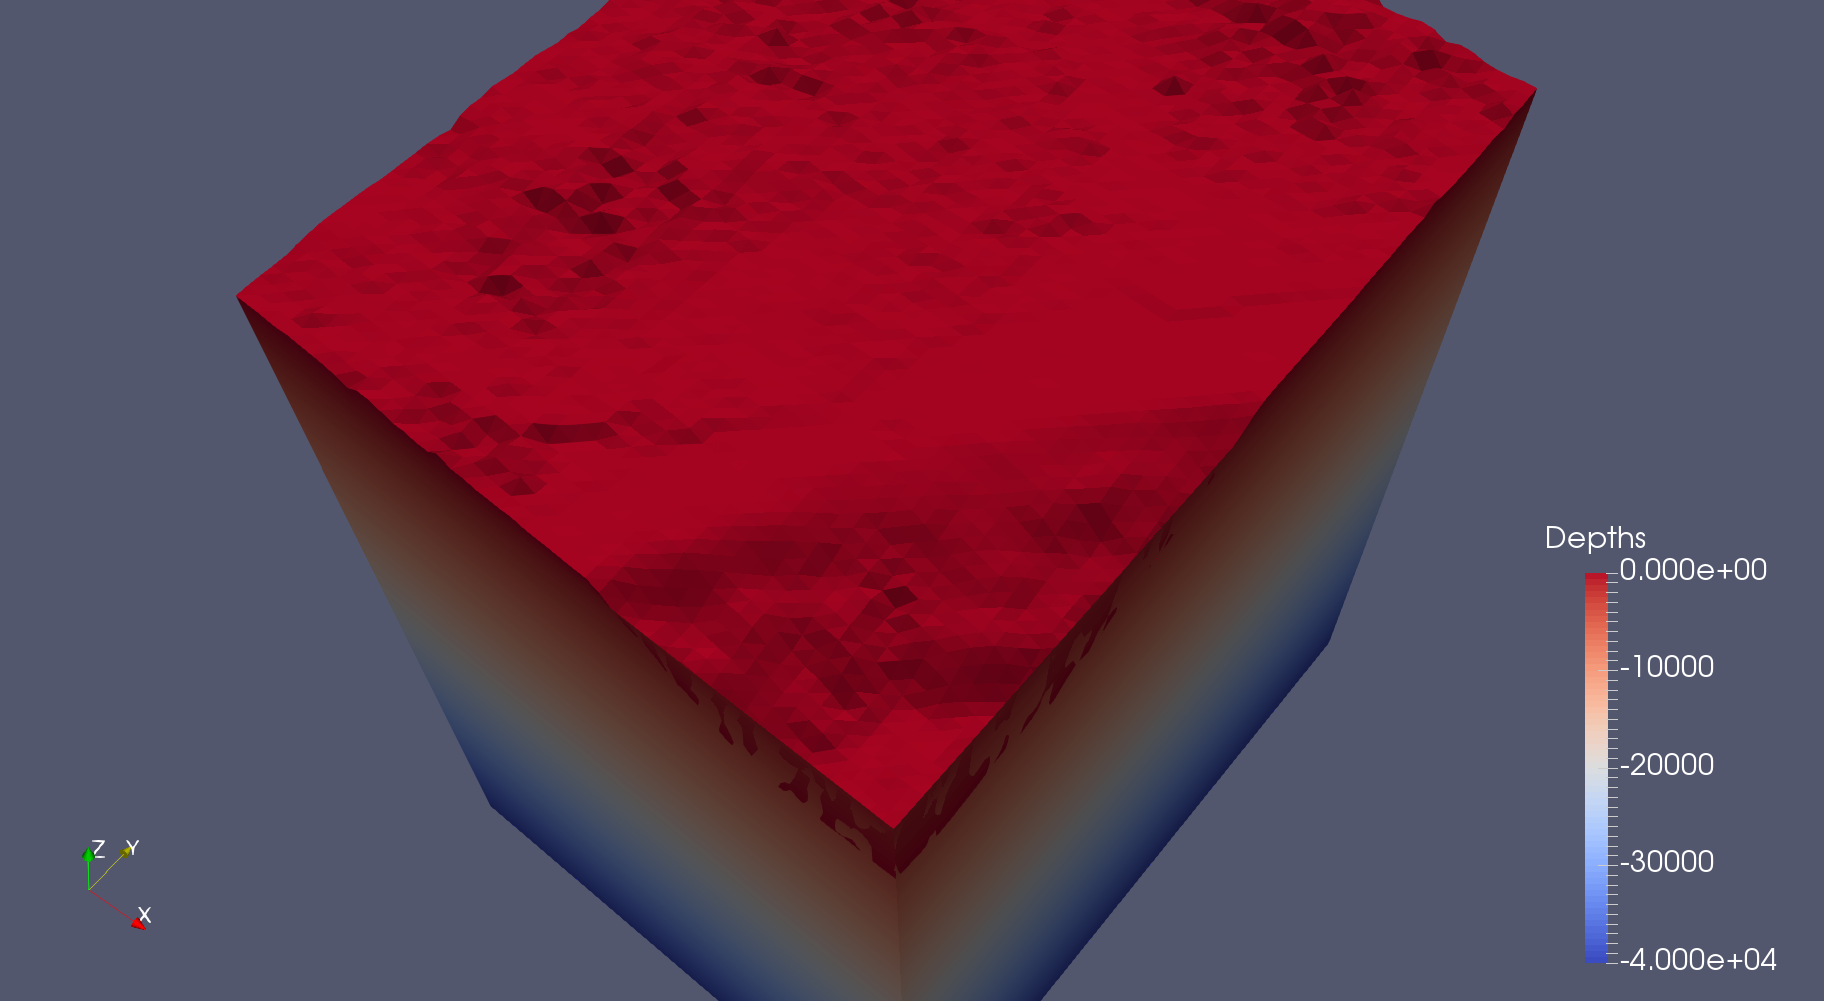

Here is the full code used to generate the figure:

In [ ]:
import underworld as uw

ds = gdal.Open(os.path.join(inDir, SydneyBasin))
nx, ny = ds.RasterXSize, ds.RasterYSize
minX, dx, _, minY, _, dy = ds.GetGeoTransform()
SydneyBasinElevation = ds.ReadAsArray()

xdim = ds.RasterXSize * math.fabs(dx)
ydim = ds.RasterYSize * math.fabs(dy)
nz, zdim = 40, 40000 

# We just set the origin to be at (0,0, -zdim)
minX, minY, minZ = (0., 0., -zdim)
maxX, maxY, maxZ = (xdim, ydim, 0.)

mesh = uw.mesh.FeMesh_Cartesian(elementType="Q1", elementRes=(nx - 1, ny - 1, nz - 1), minCoord = (minX, minY, minZ), maxCoord = (maxX, maxY, maxZ) )

top = mesh.specialSets["MaxK_VertexSet"]

mesh.reset()
with mesh.deform_mesh():
    mesh.data[top.data, 2] = SydneyBasinElevation.flatten()
    
# Lets create an HDF and XDMF file to visualize in Paraview

# Dummy field
depths = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1)
for i, (x, y, z) in enumerate(mesh.data):
    depths.data[i] = z
    
meshHandle = mesh.save(os.path.join(outDir, "SydneyBasinBad.h5"))
dataHandle = depths.save(os.path.join(outDir, "Depths.h5"))
depths.xdmf(os.path.join(outDir, 'SydneyBasinBad.xdmf'), dataHandle, 'Depths', meshHandle, 'Mesh', modeltime=0)

You can visualize the result in the notebook as well, but I would recommend using Paraview as it is really difficult to see...

In [ ]:
if is_kernel():

    Fig = glucifer.Figure(background="#51576e", border=False, axis=True)
    Fig.append(glucifer.objects.Mesh(mesh, linesize=10, opacity=0.5, name="Mesh"))

    lv = Fig.viewer(show=False)
    lv.control.Panel()
    lv.control.Range(command='scale z', range=(1,10), step=0.1, value=5)
    lv.control.ObjectList()
    lv.control.show()

## How do we fix that?

The solution consists in distributing the deformation over the height of the mesh. There are several ways to do that but an easy one is just to make sure that the spacing between nodes is constant along the z-axis (for each (x,y) locations).

In [ ]:
import numpy as np

# Define a function to distribute points at equal spacing between bottom and top
def my_func(a):
    return np.linspace(-zdim, a.max(), nz)

mesh.reset()
# Apply that fonction to the z-axis
with mesh.deform_mesh():
    cube = mesh.data[:,2].reshape(nz, ny, nx)
    mesh.data[:,2] = np.apply_along_axis(my_func, 0, cube).flatten()

We thus obtain a mesh with some topography at the top. Note that the mesh is not regular anymore...

In [ ]:
meshHandle = mesh.save(os.path.join(outDir, "SydneyBasinGood.h5"))
depths.xdmf(os.path.join(outDir, 'SydneyBasinGood.xdmf'), dataHandle, 'Depths', meshHandle, 'Mesh', modeltime=0)

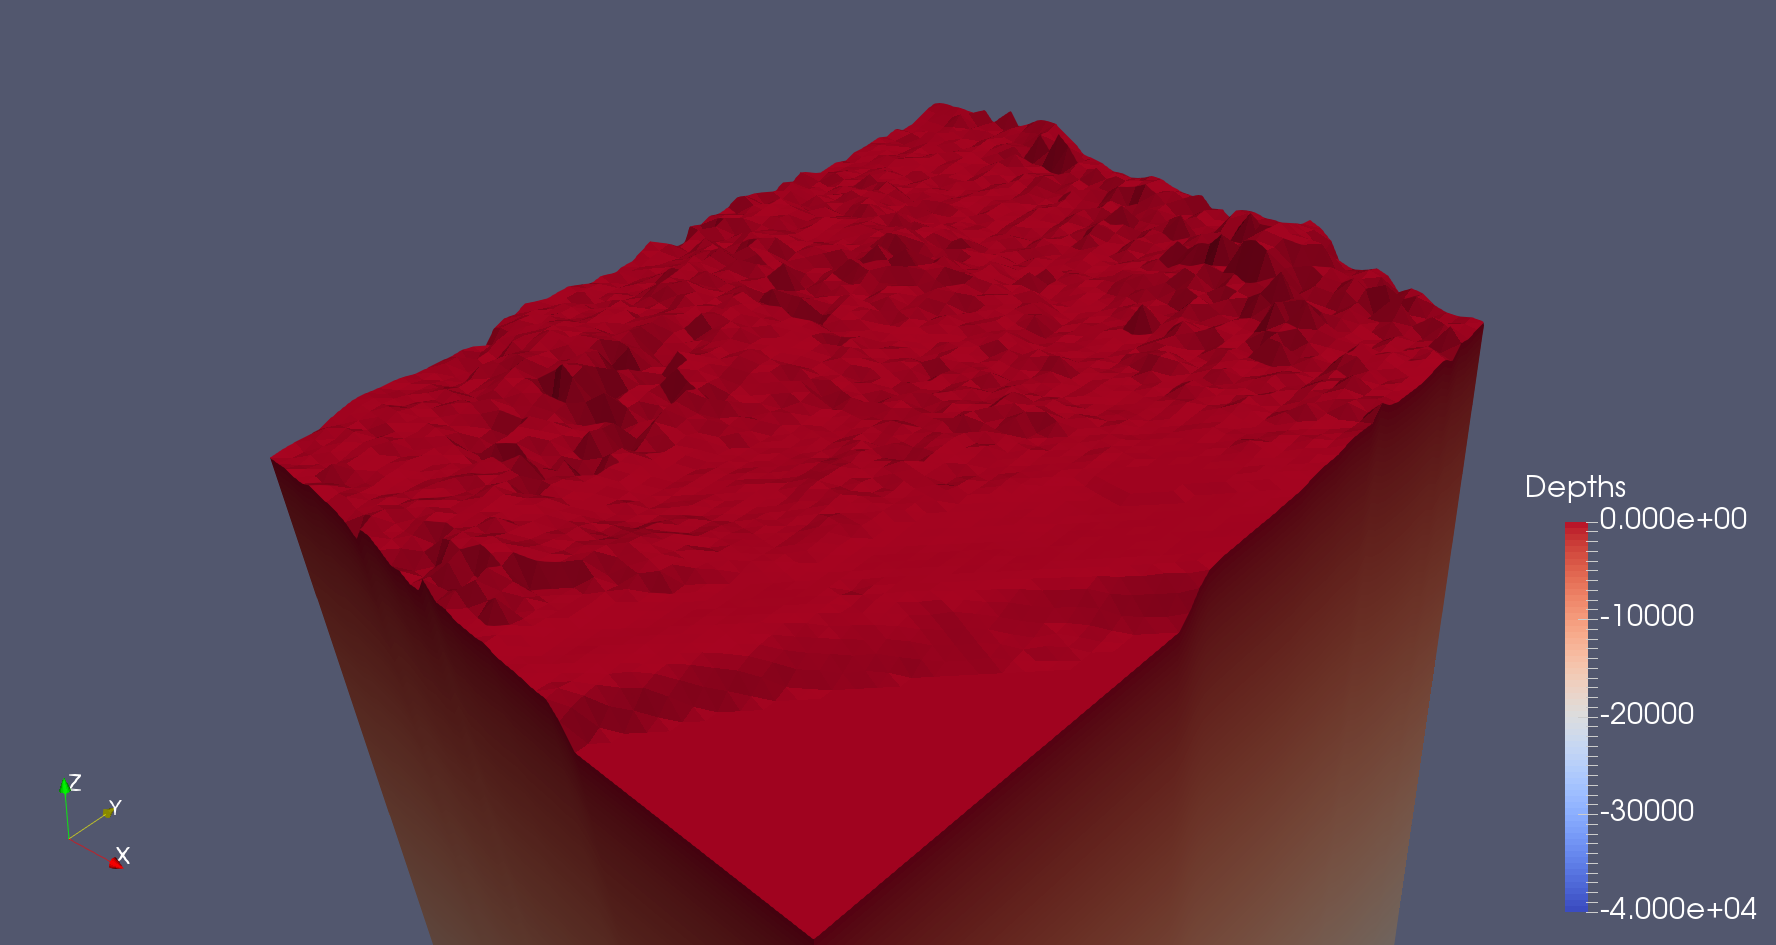

# Wrapping it up
Now as GDAL accepts a wide range of format it is easy to build a general function that will allow you to load any kind of GDAL compatible dataset and create an Underworld mesh:

In [ ]:
import gdal
import underworld as uw
import glucifer
import numpy as np

import os

inDir = "./input/"
outDir = "./outputs/"

if not os.path.exists(inDir):
    os.makedirs(inDir)
if not os.path.exists(outDir):
    os.makedirs(outDir)

def get_uw_mesh_from_DEM(DEMFile, nz, zdim):
    def distribute(a):
        return np.linspace(-zdim, a.max(), nz)

    # open the dataset
    ds = gdal.Open(DEMFile)
    # Get dimension of the grid in x and y
    nx, ny = ds.RasterXSize, ds.RasterYSize
    # Get some additional information such as spacing in x (dx) and y (dy)
    minX, dx, _, minY, _, dy = ds.GetGeoTransform()
    # Read the data as a numpy array  
    DEM = ds.ReadAsArray()
    # Calculate ranges in x, y, and z-directions
    xdim = ds.RasterXSize * np.abs(dx)
    ydim = ds.RasterYSize * np.abs(dy) 
    # We just set the origin to be at (0,0, -zdim)
    minX, minY, minZ = (0., 0., -zdim)
    maxX, maxY, maxZ = (xdim, ydim, 0.)
    
    mesh = uw.mesh.FeMesh_Cartesian(elementType="Q1", 
                                    elementRes=(nx-1, ny-1, nz-1),
                                    minCoord = (minX, minY, minZ),
                                    maxCoord = (maxX, maxY, maxZ))
    
    top = mesh.specialSets["MaxK_VertexSet"]

    with mesh.deform_mesh():
        mesh.data[top.data, 2] = DEM.flatten()
        
    with mesh.deform_mesh():
        cube = mesh.data[:,2].reshape(nz, ny, nx)
        mesh.data[:,2] = np.apply_along_axis(distribute, 0, cube).flatten()
        
    return mesh

In [ ]:
mesh = get_uw_mesh_from_DEM(os.path.join(inDir,"KingsCanyon.tif"), 40, 40000)

In [ ]:
depths = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
depths.data[...] = mesh2.data[:,2][:,np.newaxis]

mh = mesh.save(os.path.join(outDir, "KingsCanyon.h5"))
th = depths.save(os.path.join(outDir, "KingsCanyonDepths.h5"))
depths.xdmf(os.path.join(outDir, "KingsCanyon.xdmf"), th, "Depths", mh, "mesh2")

In [ ]:
if is_kernel():

    Fig = glucifer.Figure(background="#51576e", border=False, axis=True)
    Fig.append(glucifer.objects.Mesh(mesh, linesize=10, opacity=0.7, name="Mesh"))

    lv = Fig.viewer(show=False)
    lv.control.Panel()
    lv.control.Range(command='scale z', range=(1,10), step=0.1, value=5)
    lv.control.ObjectList()
    lv.control.show()

# Conclusion

We have shown how to quickly build a python function that uses a regular Digital Elevation Model to initialise an Underworld mesh with some topography.  The function leverages the GDAL library to avoid common mistakes made when calculating parameters such as spacing, number of points etc... 